In [ ]:
#Adapted from the Keras Example https://keras.io/examples/structured_data/collaborative_filtering_movielens/

In [ ]:
#to clean up the code we import warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [ ]:
df = pd.read_csv("ratings.csv")

In [ ]:
len(df)

100004

In [ ]:
df.tail(4)

,userId,movieId,rating,timestamp
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663
100003,671,6565,3.5,1074784724


In [ ]:
user_ids = df["userId"].unique().tolist()
movie_ids = df["movieId"].unique().tolist()

In [ ]:
#Make a dictionary mapping ids (keys) to indexes (values)
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
movie_id_to_index = {x: i for i, x in enumerate(movie_ids)}

In [ ]:
#Make a new column in the dataframe which contains the appropriate index for each user and movie
df["user_index"] = [user_id_to_index[i] for i in df["userId"]]
df["movie_index"] = [movie_id_to_index[i] for i in df["movieId"]]

In [ ]:
df.sample(4)

,userId,movieId,rating,timestamp,user_index,movie_index
68286,475,4270,2.5,1447239392,474,1156
15139,99,928,4.0,938587795,98,1950
29974,213,69526,3.0,1462634530,212,1607
43648,311,1099,2.0,897414235,310,4743


In [ ]:
from sklearn.preprocessing import MinMaxScaler
##Pick the range
df["rating"] = MinMaxScaler().fit_transform(df["rating"].values.reshape(-1, 1))

In [ ]:
df["rating"].describe()

count    100004.000000
mean          0.676357
std           0.235125
min           0.000000
25%           0.555556
50%           0.777778
75%           0.777778
max           1.000000
Name: rating, dtype: float64

In [ ]:
#Inputs
x = df[["user_index", "movie_index"]]
#Outputs/target
y = df["rating"]

In [ ]:
#scaling the x_train to obtain a better performing trained model and lesser time to train
x['user_index']=x['user_index']/670
x['movie_index']=x['movie_index']/9065

In [ ]:
from sklearn.model_selection import train_test_split
#Get train-test split
# obtain a high test_size (20%) to get better metrics of the model
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

In [ ]:
x_train.sample(5)

,user_index,movie_index
99897,1.000000,0.006398
2349,0.020896,0.180916
67254,0.702985,0.046001
28526,0.314925,0.018202
83249,0.840299,0.467512


In [ ]:
#Define the new class
class RecommenderNet(keras.Model):
    
    #Override init with new arguments 
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        #Make an embedding layer for users
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        #Make an embedding layer for user bias
        self.user_bias = layers.Embedding(num_users, 1)
        #Make an embedding layer for movies
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        #Make an embedding layer for movie bias
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        #inputs contains [[user,movie],[user,movie],[user,movie]...]
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        #Dot product 
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

In [ ]:
#Pick Embedding size
EMBEDDING_SIZE = 20
#Make new object (calls __init__())
num_users = len(user_ids)
num_movies = len(movie_ids)
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=0.001)
)


In [ ]:
#TRAIN
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=20,
    validation_data=(x_test, y_test)
)

Epoch 1/20
1251/1251 [==============================] - 16s 11ms/step - loss: 0.0560 - val_loss: 0.0560
Epoch 2/20
1251/1251 [==============================] - 12s 10ms/step - loss: 0.0555 - val_loss: 0.0552
Epoch 3/20
1251/1251 [==============================] - 12s 10ms/step - loss: 0.0554 - val_loss: 0.0552
Epoch 4/20
1251/1251 [==============================] - 7s 6ms/step - loss: 0.0554 - val_loss: 0.0553
Epoch 5/20
1251/1251 [==============================] - 7s 6ms/step - loss: 0.0554 - val_loss: 0.0552
Epoch 6/20
1251/1251 [==============================] - 8s 6ms/step - loss: 0.0554 - val_loss: 0.0553
Epoch 7/20
1251/1251 [==============================] - 7s 6ms/step - loss: 0.0554 - val_loss: 0.0552
Epoch 8/20
1251/1251 [==============================] - 7s 6ms/step - loss: 0.0553 - val_loss: 0.0552
Epoch 9/20
1251/1251 [==============================] - 8s 6ms/step - loss: 0.0554 - val_loss: 0.0552
Epoch 10/20
1251/1251 [==============================] - 7s 6ms/step - loss:

In [ ]:
model.user_embedding.trainable_weights[0].numpy()

array([[-2.3408090e-03,  2.4463711e-03,  9.1342971e-02, ...,
         1.2082976e-03, -9.0303971e-04,  4.0937057e-03],
       [-3.7118573e-02,  2.4850855e-02,  1.7433754e-01, ...,
         1.7154716e-02,  1.7971825e-02,  4.3392878e-02],
       [-4.5668644e-30,  4.5261189e-30,  4.5999291e-30, ...,
        -4.5879296e-30,  4.6935184e-30, -4.6387155e-30],
       ...,
       [-4.5300250e-30, -4.6695815e-30,  4.6122264e-30, ...,
         4.5343339e-30,  4.6241033e-30, -4.5025684e-30],
       [-4.6129152e-30,  4.5623622e-30, -4.5360789e-30, ...,
         4.5302085e-30, -4.6482127e-30, -4.5658646e-30],
       [ 4.6285998e-30,  4.5030379e-30, -4.6468800e-30, ...,
         4.5922927e-30,  4.6586436e-30,  4.6435574e-30]], dtype=float32)

In [ ]:
#Get the movie data so we can map back to names
movie_data = pd.read_csv("movies.csv")

### Making predictions and `argsort()`

Once we have the predicted ratings for each film, we need to get the **Top N**

Here we use `np.argsort()`, which does the sort based on the **ratings** but returns the **indexes** rather than the **ratings themselves**. We can then use this to look up the `movie_ids` and then the `title`.

In [ ]:
user = 3
n = 10
#For one user, make a pair with every movie index
x = [[user, i] for i in np.arange(num_movies)]

In [ ]:
#Predict
predicted_ratings = model.predict(x).flatten()
#Get Top-N indexes
top_n_indexes = predicted_ratings.argsort()[-n:]
#Get Movie Names
top_n = [movie_data[movie_data["movieId"]==movie_ids[i]]["title"] for i in top_n_indexes]

In [ ]:
top_n

[3655    Scenes from the Class Struggle in Beverly Hill...
 Name: title, dtype: object, 4643    This Boy's Life (1993)
 Name: title, dtype: object, 407    Geronimo: An American Legend (1993)
 Name: title, dtype: object, 7901    The Artist (2011)
 Name: title, dtype: object, 8084    Magic Mike (2012)
 Name: title, dtype: object, 4884    Love Actually (2003)
 Name: title, dtype: object, 3919    Mrs. Soffel (1984)
 Name: title, dtype: object, 5901    Sound and Fury (2000)
 Name: title, dtype: object, 2260    Hamlet (1964)
 Name: title, dtype: object, 30    Dangerous Minds (1995)
 Name: title, dtype: object]

# Practice

Personal note dont forget to comment code

## Task 1

We're going to ask you take the trained model and write the code to make two metrics - **Diversity** and **Novelty**. You should end up with **one statistic** for each that tells you something about the recommendations of the trained model based on the **whole dataset**.


#### Pro Tip

This will take quite a long time to run on the whole dataset, so start off by trying to get the code to work for **one user**, then expand to **two users**, then **every user**.

### Diversity 

This tells us what the mean diversity (1-similarity, based on movie embeddings) between each film in every users Top 10 films is. 

1. Calculate every user's top 10


2. For each top 10, calculate the similarity matrix


3. 1-similarity to get the difference


4. Get mean difference for each top 10 


5. Report the mean for whole dataset (every top 10)


### Novelty 

This tells us what the mean popularity (e.g. mean rating) of the films in every users Top 10 films is 

1. Calculate every user's top 10


2. For each top 10, get the mean rating for each film (based on the original **MovieLens Small** dataset (``df = pd.read_csv("ratings.csv")``). 


3. Get the mean rating for each top 10.


4. Report the mean for the whole dataset (every top 10).



## Task 2

Using a dimensionality reduction approach, plot the top 30 best rated films on a 2-D graph based on their movie embeddings. Label each point with the title.



In [ ]:
# Specify 'n' to limit movies to top 10 only
n = 10

# Create a list to store indexes of all users top 10 movies.
top_n_indexes = []

# Loops each user (p) from length of user_ids and predicts their ratings for each movie.
# Sorts in ascending order and takes the last 10 (-n)
for p in range(len(user_ids)):
    x = [[p, i] for i in np.arange(num_movies)]
    predicted_ratings = model.predict(x).flatten()
    indexes = predicted_ratings.argsort()[-n:]
    top_n_indexes.append(indexes)

print(top_n_indexes)

[array([2943, 4472, 4750, 7738,  370, 2851, 7383, 4425,   16,    0]), array([4750, 7738,  370, 2851, 7383, 4425,    7,    9,   16,    0]), array([6785, 2943, 4472, 4750, 7738,  370, 2851, 7383, 4425,    0]), array([6785, 2943, 4472, 4750, 7738,  370, 2851, 7383, 4425,    0]), array([6785, 2943, 4472, 4750, 7738,  370, 2851, 7383, 4425,    0]), array([6785, 2943, 4472, 4750, 7738,  370, 2851, 7383, 4425,    0]), array([6785, 2943, 4472, 4750, 7738,  370, 2851, 7383, 4425,    0]), array([6785, 2943, 4472, 4750, 7738,  370, 2851, 7383, 4425,    0]), array([6785, 2943, 4472, 4750, 7738,  370, 2851, 7383, 4425,    0]), array([6785, 2943, 4472, 4750, 7738,  370, 2851, 7383, 4425,    0]), array([6785, 2943, 4472, 4750, 7738,  370, 2851, 7383, 4425,    0]), array([6785, 2943, 4472, 4750, 7738,  370, 2851, 7383, 4425,    0]), array([6785, 2943, 4472, 4750, 7738,  370, 2851, 7383, 4425,    0]), array([6785, 2943, 4472, 4750, 7738,  370, 2851, 7383, 4425,    0]), array([6785, 2943, 4472, 4750, 77

In [ ]:
# Create variable for accessing movie embedding weights
movie_weights = model.movie_embedding.trainable_weights[0].numpy()

In [ ]:

# Create a list to store embedding weights for each movie (671 users, 10 movies per user, 20 weights per movie)
top_n_weights = []

# Loops each user's top 10 movies (row) from the index list
# Matches movie index with relevant embedding weights
for row in top_n_indexes:
    top_n_weights.append(movie_weights[row])

Novelty

In [ ]:
# Create list to store all ratings for each movie
movie_ratings =[]

# Finds ratings and matches them to their movie based on movie index
for each_movie in df['movie_index']:
    find_rating = df.loc[df['movie_index'] == each_movie, 'rating']
    movie_ratings.append(find_rating)

In [ ]:
movie_ratings_array = np.array(movie_ratings)

In [ ]:
# Create a list to store all the movie ratings from each user's top movies. (671 users, 10 movies per user, all ratings per movie)
top_n_ratings = []

# Loops each user's top 10 movies (row) from the index list
# Matches movie index with relevant movie rating
for row in top_n_indexes:
    top_n_ratings.append(movie_ratings_array[row])

# Prints all ratings from user0, movie1
print(top_n_ratings[0][1])

4472     0.333333
18339    0.777778
41722    0.777778
Name: rating, dtype: float64


In [ ]:
# Create a list to store popularity scores for each user
pop_per_user = []

# Loops each user, then each movie from the list of ratings
# Calculates mean novelty
for each_user in top_n_ratings:
    for each_movie in each_user:
        novelty = each_movie.mean()
        pop_per_user.append(novelty)

# Condense scores from all users into one total mean score
total_pop = np.array(pop_per_user).mean()
print(total_pop)

0.6764583915776125


In [ ]:
#Task 2
# Remove all movies with only 1 rating
# for loop will take lesser time than a while loop in this aspect
filtered_movie_ratings = []
for i in movie_ratings:
    if len(i) != 1:
        filtered_movie_ratings.append(i)

In [ ]:

# Create a list to store the average rating for each movie
avg_rating = []

for row in filtered_movie_ratings:
    avg = row.mean()
    avg_rating.append(avg)

# Sort the ratings and return indexes
top_30_ratings = np.array(avg_rating).argsort()[-30:]
print(top_30_ratings)

[14422 32066 79416   804 81929 77875  1348 37536 55524 89825 89355 58840
  8453 52466 37345 77261 40556  4497 23089  5519 86086 14436 73042 45220
 31485 90854 52278 55289 72908 56153]


In [ ]:
#Load movie data
movie_data = pd.read_csv("movies.csv")

In [ ]:
# Convert movie index back to ID
top_30_movies = [df['movie_index'][i] for i in top_30_ratings]

# Map ID to title
movie_names = [movie_data[movie_data["movieId"]==movie_ids[i]]["title"] for i in top_30_movies]

In [ ]:
# Create a list to store embeding weights for each movie (30 movies, 20 weights per movie)
top_30_weights = []

# Loops each movie and matches it to its embedding weight
for i in top_30_movies:
    top_30_weights.append(movie_weights[i])

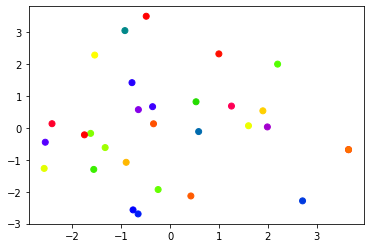

In [ ]:
# Fit array of weights and condense to 2d
x = StandardScaler().fit_transform(top_30_weights)
pca = PCA(n_components=2)
x_2d = pca.fit_transform(x)

# Plot
x = x_2d[:,0]
y = x_2d[:,1]
plt.scatter(x,y, c=np.arange(0,30), cmap='prism')

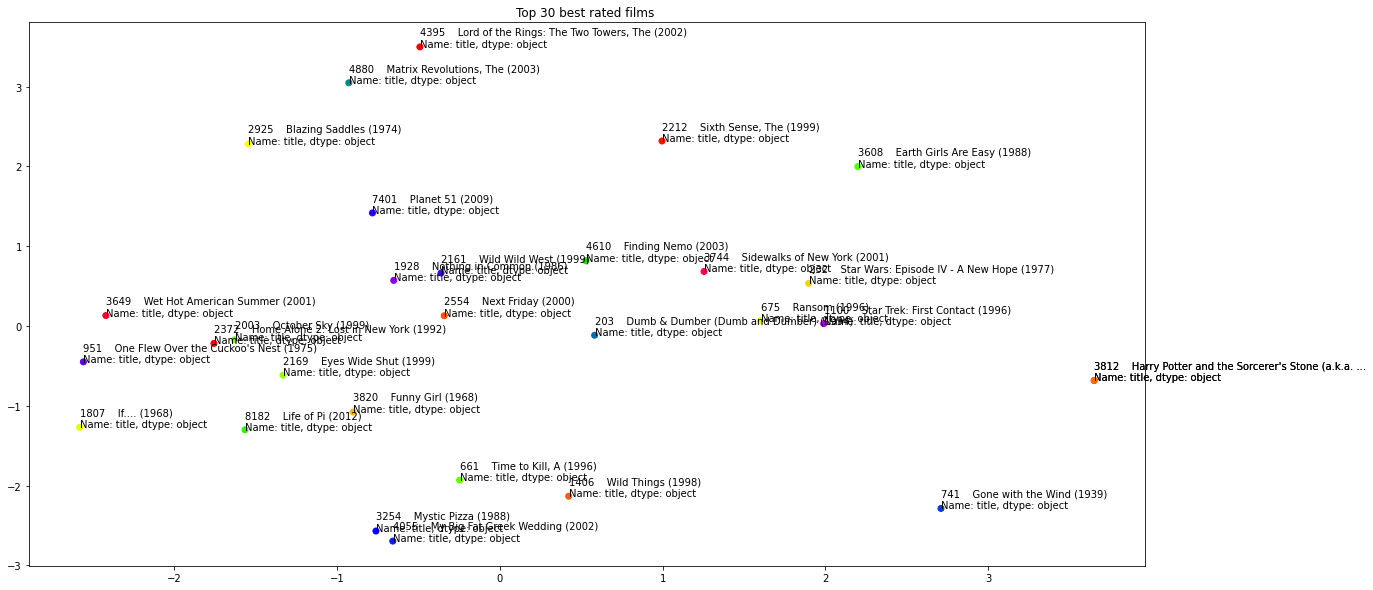

In [ ]:
# Plot with movie names
fig,ax = plt.subplots(figsize = (20,10)) #better visibility
plt.title('Top 30 best rated films ')
ax.scatter(x,y, c=np.arange(0,30), cmap='prism')
annotations = pd.Series(movie_names).astype(str)
for i, label in enumerate(annotations):
    ax.annotate(label, (x[i], y[i]))